In [12]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from aggclass import AgglomerativeEnsemble
from aggclass.helpers import stratified_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

def exp(n_unlabeled=100, n_labeled_per_class=1, noise=0.1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    accuracies = np.zeros(2)
    
    n_labeled=2*n_labeled_per_class
    
    X, y = make_moons(10000, noise=noise)
    perm = np.random.choice(10000, 10000, replace=False)

    X_labeled_1 = X[perm][np.where(y[perm] == 0)[0][:n_labeled_per_class]]
    X_labeled_2 = X[perm][np.where(y[perm] == 1)[0][:n_labeled_per_class]]
    X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)
    
    del X, y
    
    y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))
    
    X, y = make_moons(20000, noise=noise)
    X_unlabeled = X[:n_unlabeled]
    y_unlabeled = y[:n_unlabeled]
        
    X_test, y_test = make_moons(1000, noise=noise)
    
    del X, y
    
#     clf=SVC()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[1] = (y_test == y_hat).mean()
    
    
#     clf=DecisionTreeClassifier()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[2] = (y_test == y_hat).mean()
    
    
    clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[1] = (y_test == y_hat).mean()

    
    y_ = -1 * np.ones(n_labeled + n_unlabeled)
    y_[:n_labeled] = y_labeled.copy()

    n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[0] = (y_test == y_hat).mean()
    
#     clf=LabelPropagation(n_neighbors=1)
#     clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
#     y_hat=clf.predict(X_test)
#     accuracies[4] = (y_test == y_hat).mean()
    
#     clf=LabelSpreading(n_neighbors=1)
#     clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
#     y_hat=clf.predict(X_test)
#     accuracies[5] = (y_test == y_hat).mean()
    
        
    print(n_unlabeled, n_labeled, accuracies)

    return accuracies

In [22]:
n_labeled=1
n_labeled_list = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
condensed_func = lambda x: exp(x, n_labeled, 0.1)

n_mc=720
n_cores=90

algos = ['HADR', '1-NN']

func_tuples = []
for n_labeled_ in n_labeled_list:
    for i in range(n_mc):
        func_tuples.append(n_labeled_)
        
accuracies_list = Parallel(n_jobs=n_cores)(delayed(condensed_func)(x) for x in func_tuples)

In [23]:
accuracies=np.zeros((len(algos), len(n_labeled_list), n_mc))

for i in range(len(n_labeled_list)):
    for j in range(n_mc):
        accuracies[0, i, j] = accuracies_list[int(i*n_mc + j)][0]
        accuracies[1, i, j] = accuracies_list[int(i*n_mc + j)][1]
#         accuracies[2, i, j] = accuracies_list[int(i*n_mc + j)][2]
#         accuracies[3, i, j] = accuracies_list[int(i*n_mc + j)][3]
#         accuracies[4, i, j] = accuracies_list[int(i*n_mc + j)][4]
#         accuracies[5, i, j] = accuracies_list[int(i*n_mc + j)][5]

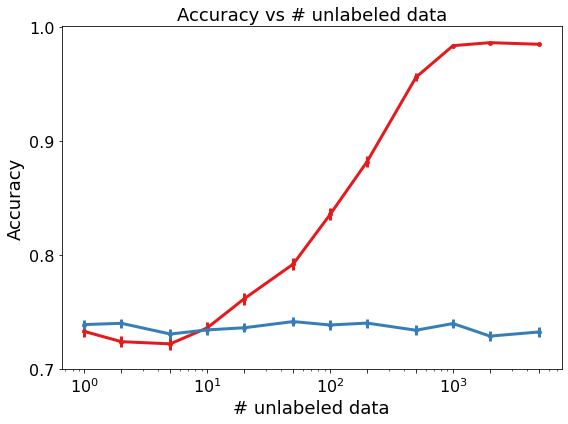

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

colors= sns.color_palette('Set1', n_colors=len(algos))

ax.set_xscale('log')
for i, algo in enumerate(algos):
    if i >= 5:
        ci = i+1
    else:
        ci = i
    ax.scatter(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], label=algo, s=15)
    ax.errorbar(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], lw=3, yerr=np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))

#     for j, n_labeled in enumerate(n_labeled_list):
#         if j > 0:
#             continue
#         ax.scatter([n_labeled + (i-1)/2.5]*n_mc, accuracies[i, j], color=colors[i], s=1, alpha=1)
    
    
# ax.legend(fontsize=18)
ax.set_xlabel('# unlabeled data', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_title('Accuracy vs # unlabeled data', fontsize=18)


    
ax.set_yticks([0.7,0.8,0.9,1])
ax.tick_params(labelsize=16)
ax.set_xticks(n_labeled_list)

plt.tight_layout()
plt.savefig('figures/moons_unlabeled.pdf')